In [108]:
import sys, os, re
import importlib
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d, percentile_filter
from scipy.stats import binned_statistic, zscore
import scipy.stats as stats
import suite2p 
from suite2p.extraction import dcnv
import pandas as pd
import yaml
import copy
import glob 
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import wesanderson
from cycler import cycler
import palettes
import subprocess
import json
pio.renderers.default = "browser"

import neural_analysis_helpers
importlib.reload(neural_analysis_helpers)

from neural_analysis_helpers import get_psth, plot_avg_psth, split_psth, get_tuned_neurons, plot_avg_goal_psth, \
    get_landmark_psth, plot_avg_landmark_psth, plot_landmark_psth_map, plot_condition_psth_map, get_map_correlation, \
    get_tuned_neurons_shohei, plot_goal_psth_map, plot_all_sessions_goal_psth_map, get_map_correlation_matrix, \
    get_landmark_ids, get_landmark_categories, load_vr_behaviour_data, get_imag_rew_idx, load_nidaq_behaviour_data, \
    get_landmark_category_rew_idx

# import roi_tracking_helpers
# importlib.reload(roi_tracking_helpers)
# from roi_tracking_helpers import roicat_visualize_tracked_rois

import parse_session_functions
importlib.reload(parse_session_functions)
from parse_session_functions import load_session, load_config, create_session_struct, get_lap_idx, get_lm_idx, calc_laps_needed, get_active_goal, get_rewarded_lms, get_lms_visited

tm_palette = palettes.met_brew('Tam',n=123, brew_type="continuous")
tm_palette = tm_palette[::-1]
color_scheme = wesanderson.film_palette('Darjeeling Limited',palette=0)
custom_cycler = cycler(color=color_scheme)

hfs_palette = np.array(palettes.met_brew('Archambault',n=20, brew_type="continuous"))

##### Load data

In [79]:
# Load tracked and aligned ROIs
sessions_to_align = ["ses-010_date-20250314_protocol-t4", "ses-011_date-20250315_protocol-t5"] #, "ses-012_date-20250318_protocol-t6"]
num_sessions = len(sessions_to_align)
protocol_nums = [int(re.search(r'protocol-t(\d+)', s).group(1)) for s in sessions_to_align]

basepath = Path('/Volumes/mrsic_flogel/public/projects/AtApSuKuSaRe_20250129_HFScohort2')
animal = 'TAA0000066'
func_img_path = 'funcimg/Session'
alignment_path = basepath / animal / '_'.join(f't{n}' for n in protocol_nums)
savepath = alignment_path / 'analysis' 

roicat_dir = r'/Users/athinaapostolelli/Documents/SWC/VR_ABCD_project/ROICaT'
roicat_data_name = animal 

suffix = '_'.join(f't{n}' for n in protocol_nums)
filename = f'roicat_aligned_ROIs_{suffix}.npy'
if os.path.exists(os.path.join(alignment_path, filename)):
    idx_original_aligned = np.load(os.path.join(alignment_path, filename))
else:
    raise FileNotFoundError('The ROICaT alignment file is not found in this directory.')
    

In [80]:
# Load DF_F 
session_data = [[] for s in range(num_sessions)]

for s, sess in enumerate(sessions_to_align):
    DF_F_file = os.path.join(basepath, animal, sess, func_img_path, 'suite2p/plane0/DF_F0.npy')
    valid_frames_file = os.path.join(basepath, animal, sess, 'valid_frames.npz')

    if os.path.exists(DF_F_file) and os.path.exists(valid_frames_file):
        valid_frames = np.load(valid_frames_file)['valid_frames']

        DF_F_all = np.load(DF_F_file)
        DF_F = DF_F_all[:, valid_frames]
        session_data[s] = DF_F
    else:
        raise FileNotFoundError('Either the valid_frames.npz or the DF_F0.npy file does not exist in this directory.')


Common neurons considered across all sessions: 106


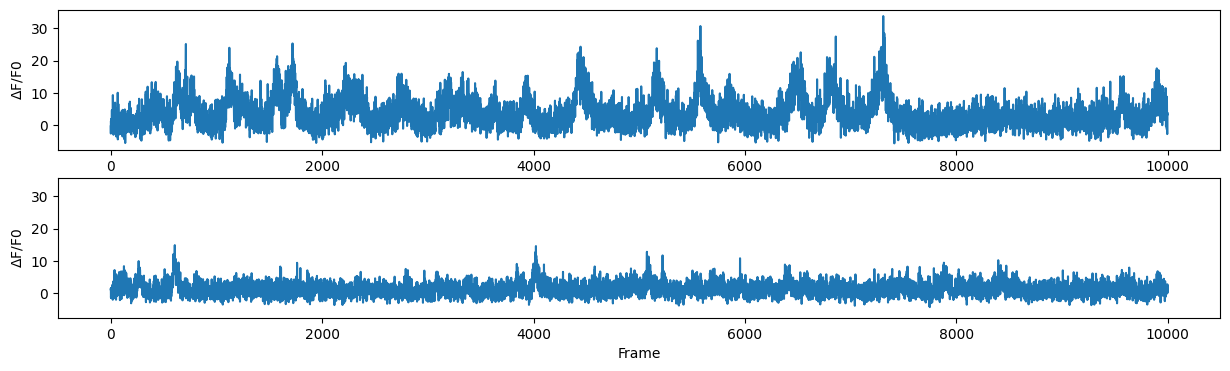

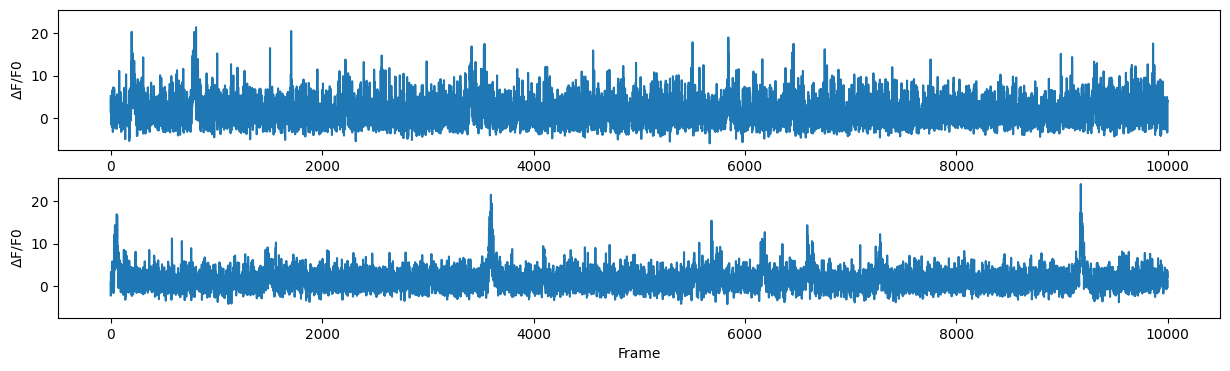

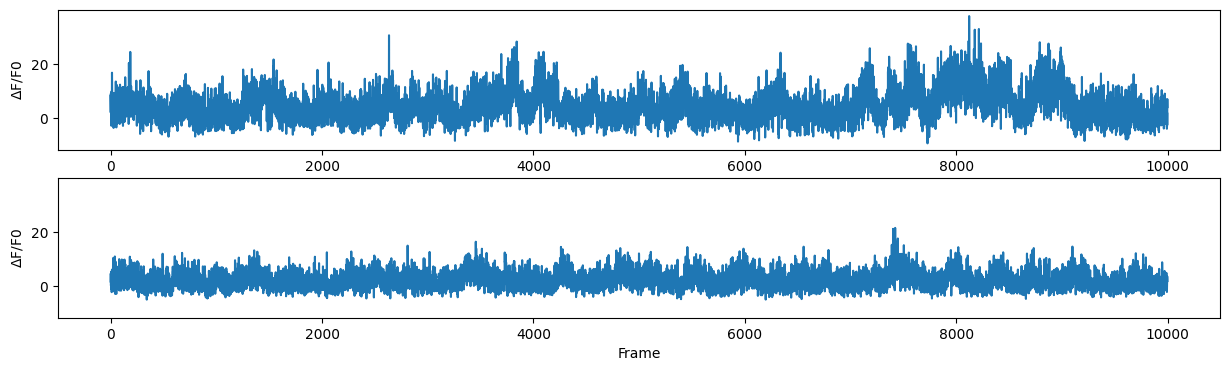

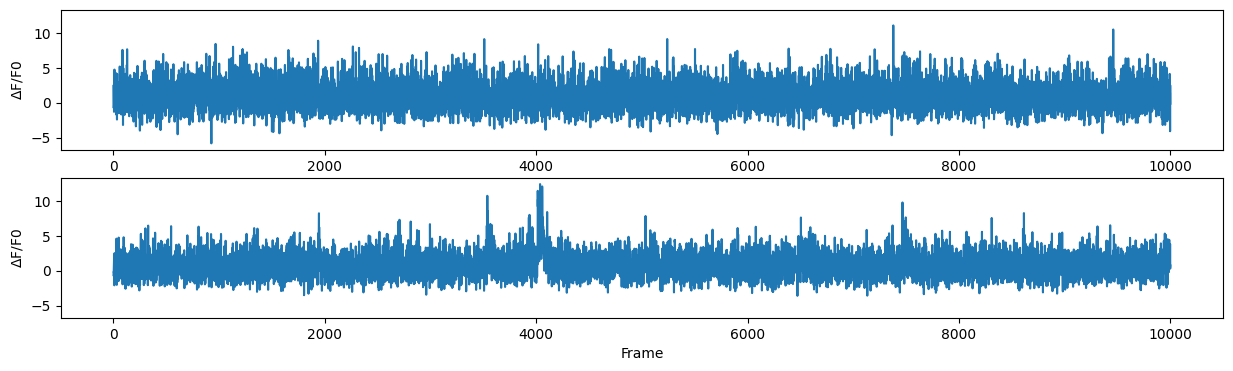

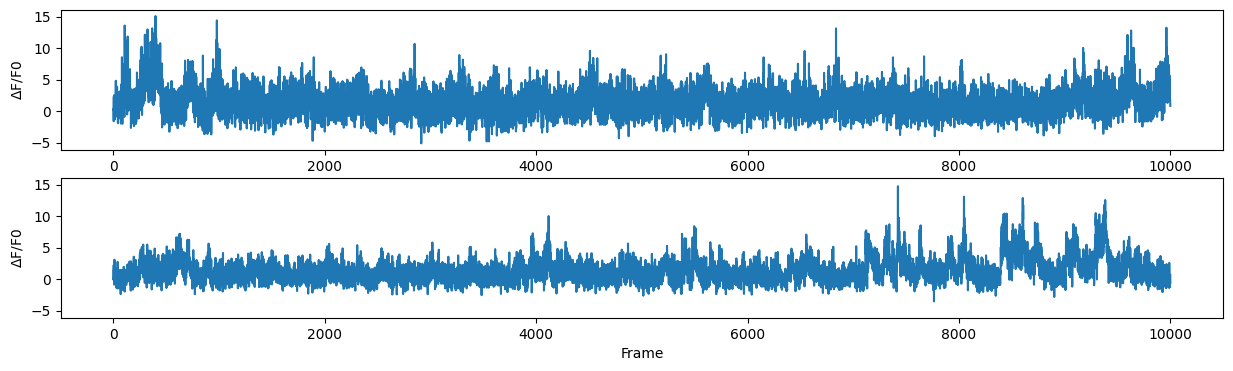

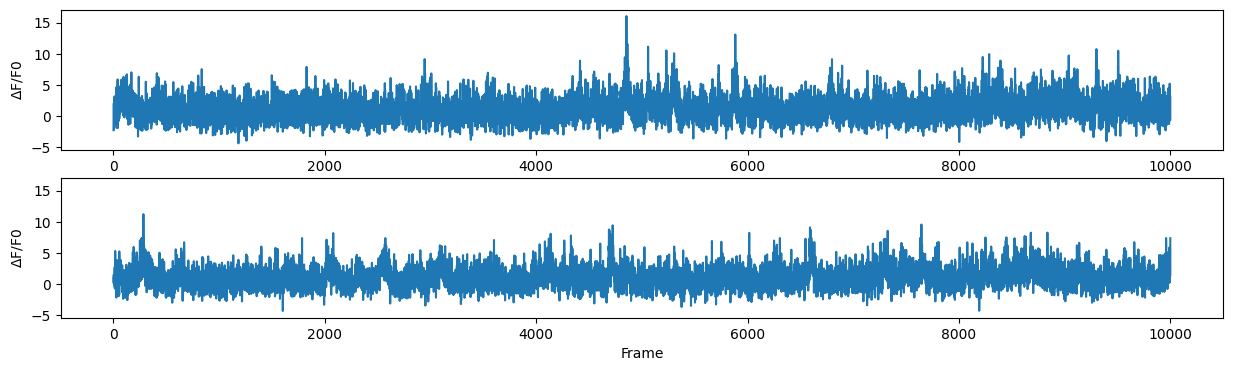

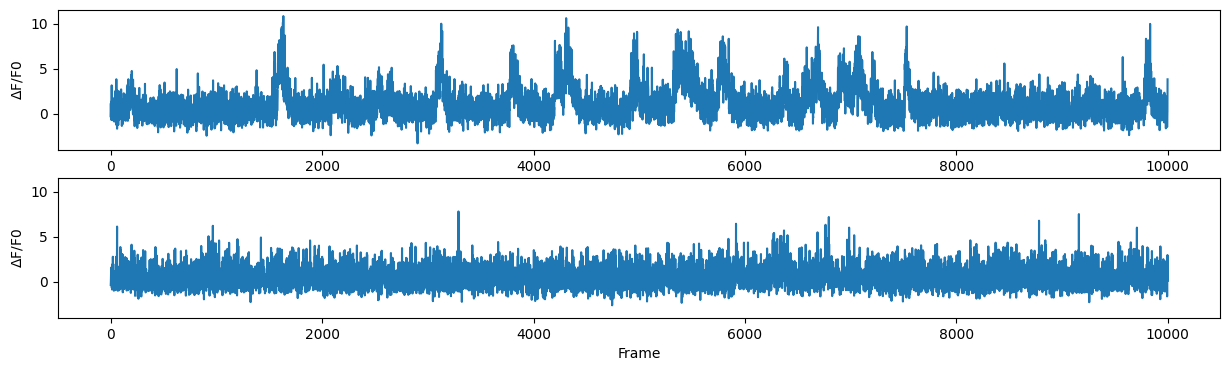

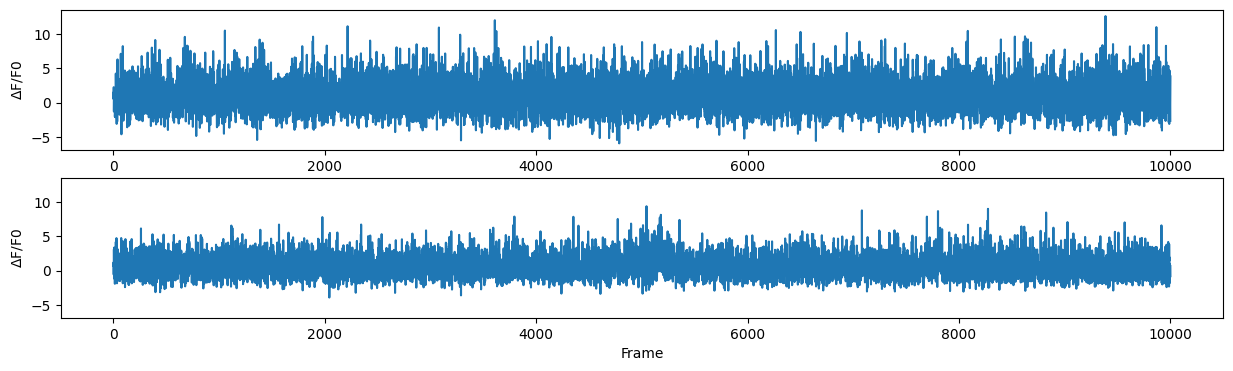

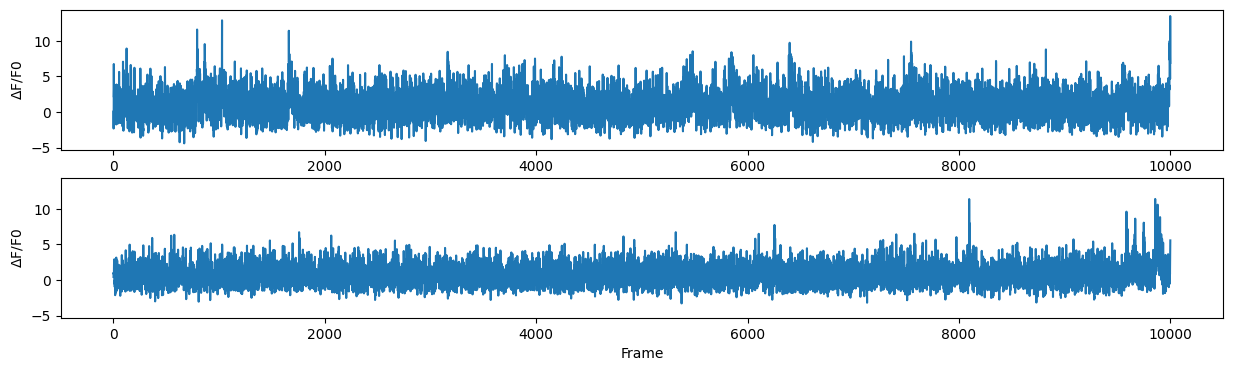

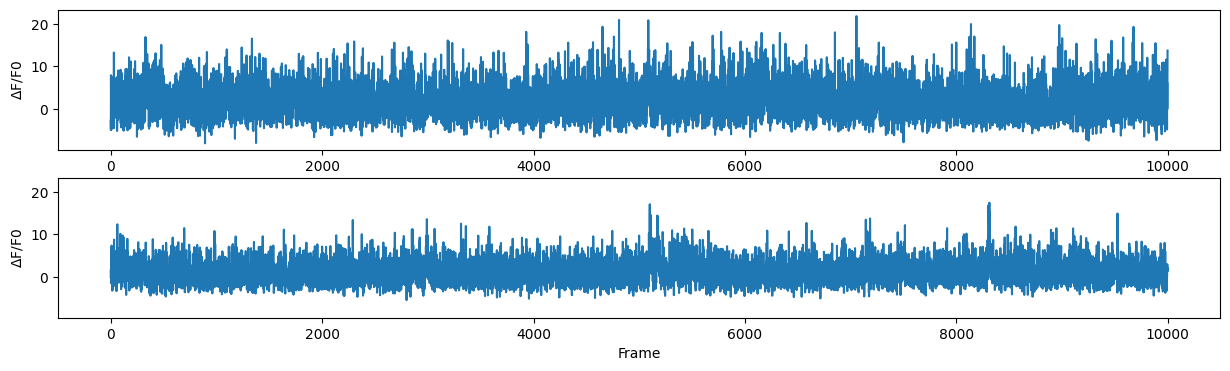

In [81]:
# Look at distribution of DF/F to select neurons

# Keep neurons that have been clustered in all sessions
idx_array = np.vstack(idx_original_aligned)  # shape: (n_sessions, n_neurons)
valid_mask = np.all(~np.isnan(idx_array), axis=0)  # Find neurons that are not nan in all sessions
valid_indices = np.where(valid_mask)[0]  # Get the indices that are valid across all sessions

# Find indices of neurons that have good signal in all sessions and are tracked across sessions
consistent_neurons = [[] for s in range(num_sessions)]
for s in range(num_sessions):
    for n, neuron in enumerate(np.array(idx_original_aligned[s][valid_indices]).astype(int)):
        deltas = session_data[s][neuron,:] - np.mean(session_data[s][neuron,:])
        # plt.hist(deltas, bins=100)
        skew = stats.skew(deltas)

        if skew > 0.5:
            consistent_neurons[s].append(n)

neuron_sets = [set(neurons) for neurons in consistent_neurons]
common_neuron_idx = list(set.intersection(*neuron_sets))  # indices of neurons
print("Common neurons considered across all sessions:", len(common_neuron_idx))

# Get the ids of these neurons  
neurons_considered_sessions = [[] for s in range(num_sessions)]  
for s in range(num_sessions):
    for neuron in np.array(idx_original_aligned[s][valid_indices[common_neuron_idx]]).astype(int):
        neurons_considered_sessions[s].append(neuron)

# Plot a few neurons
plot_range = 10000
xdata = np.arange(0, plot_range) 
for n in range(0,10):
    fig, ax = plt.subplots(num_sessions, 1, figsize=(15,4), sharey=True)
    ax = ax.ravel()
    for s in range(num_sessions):
        ax[s].plot(xdata, session_data[s][neurons_considered_sessions[s][n],0:plot_range])
        ax[s].set_xlabel('Frame')
        ax[s].set_ylabel('$\Delta$F/F0')

In [82]:
# Identify common neurons that are tuned to rewards
# NOTE: singificant neurons for each event are indices into that session's neurons_considered, 
# which are in turn the actual ROI ids. 

time_around = 0.5  # window around events

all_significant_neurons_reward = [[] for s in range(num_sessions)]
significant_neurons_reward_id = [[] for s in range(num_sessions)]
reward_tuned_neurons_sessions = [[] for s in range(num_sessions)]
neurons_considered = [[] for s in range(num_sessions)]
tracked_reward_tuned_neurons = [[] for s in range(num_sessions)] # reward-tuned neurons across sessions
tracked_reward_tuned_idx = [[] for s in range(num_sessions)]
results_rewards = [[] for s in range(num_sessions)]

for s, (prot, sess) in enumerate(zip(protocol_nums, sessions_to_align)):

    analysis_path = os.path.join(basepath, animal, sess, 'analysis')
    neurons_considered_file = np.load(os.path.join(analysis_path, f'T{prot}_neurons_considered.npz'), allow_pickle=True)
    neurons_considered[s] = neurons_considered_file['arr_0']

    results_rewards[s] = np.load(os.path.join(analysis_path, f'T{prot}_rewards_analysis_{time_around}s.npz'), allow_pickle=True)
    all_significant_neurons_reward[s] = results_rewards[s]['all_significant_neurons_reward']

    # Reward-tuned neurons for each goal, where the keys correspond to goals: 1:A, 2:B, 3:C, 4:D
    if 'significant_neurons_reward_id' in results_rewards[s]:
        significant_neurons_reward_id[s] = results_rewards[s]['significant_neurons_reward_id']
    else:
        significant_neurons_reward_id[s] = None  

    # Ids of reward-tuned neurons from each session
    reward_tuned_neurons_sessions[s] = neurons_considered[s][all_significant_neurons_reward[s]]

    # Ids of reward-tuned neurons from each session that have been tracked across sessions
    tracked_reward_tuned_neurons[s] = np.intersect1d(reward_tuned_neurons_sessions[s], neurons_considered_sessions[s])
    print(f'Out of {len(neurons_considered_sessions[s])} neurons considered across all sessions, {len(tracked_reward_tuned_neurons[s])} have been previously identified as reward-tuned in T{prot}.')

    # Indices of reward-tuned neurons from each session inside the tracked array. 
    # The same indices across arrays correspond to the same neurons.
    tracked_reward_tuned_idx[s] = np.where(np.isin(neurons_considered_sessions[s], tracked_reward_tuned_neurons[s]))[0]

# Indices of tracked neurons that are reward-tuned across sessions.
consistent_reward_tuned_neuron_idx = reduce(np.intersect1d, tracked_reward_tuned_idx)


Out of 106 neurons considered across all sessions, 56 have been previously identified as reward-tuned in T4.
Out of 106 neurons considered across all sessions, 68 have been previously identified as reward-tuned in T5.


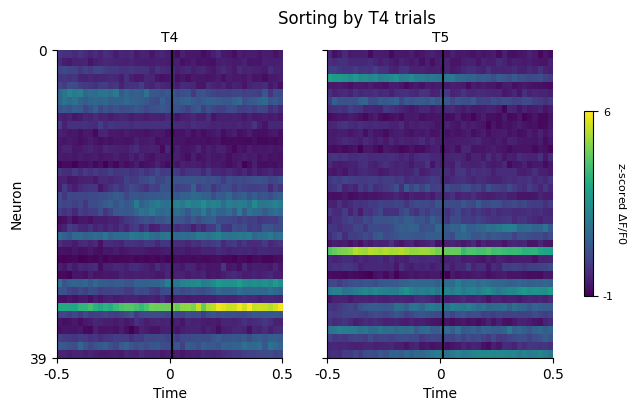

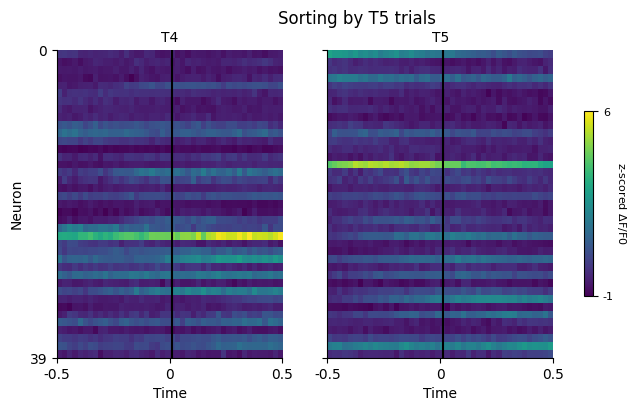

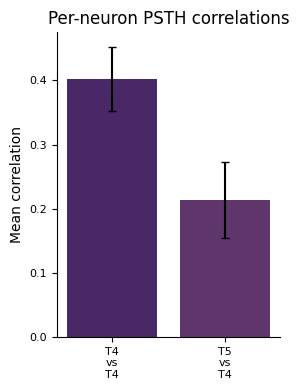

In [47]:
# Plot reward PSTHs for each session
psths = [[] for s in range(num_sessions)]
average_psths = [[] for s in range(num_sessions)]
conditions = [f'T{prot}' for prot in protocol_nums]

for s in range(num_sessions):   
    neurons = np.array(neurons_considered_sessions[s])[consistent_reward_tuned_neuron_idx]  # ids of tracked neurons that are consistently reward-tuned 
    neuron_idx = np.where(np.isin(neurons_considered[s], neurons))[0]   # indices of these neurons inside their original list of neurons considered 

    # print(results_rewards[s]['average_reward_psth'].shape)
    average_psths[s] = results_rewards[s]['average_reward_psth'][neuron_idx]
    psths[s] = results_rewards[s]['reward_psth'][neuron_idx]

plot_condition_psth_map(average_psths, conditions, zscoring=True, time_around=time_around, funcimg_frame_rate=45, save_plot=False, savepath=savepath, savedir='RewardPSTH_RewardTunedNeurons')

corrs = get_map_correlation(psths, average_psths, conditions, zscoring=True, reference=0, color_scheme=hfs_palette[np.array(protocol_nums)], \
                            save_plot=False, savepath=savepath, savedir='RewardPSTH_RewardTunedNeurons', filename='FiringMap_correlation')
    

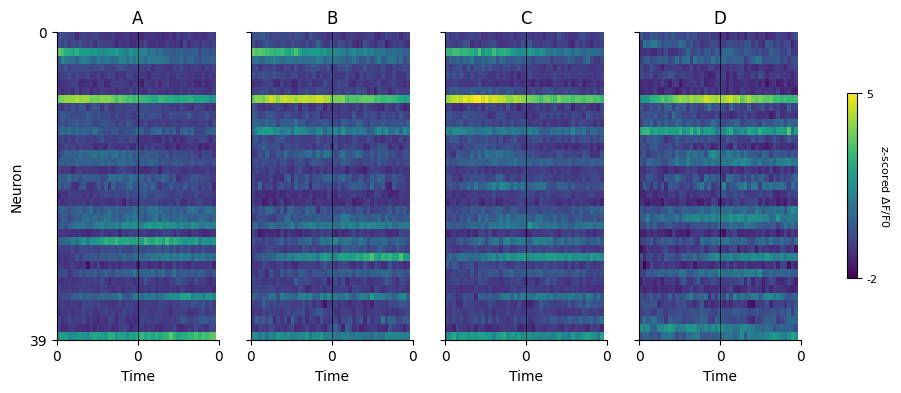

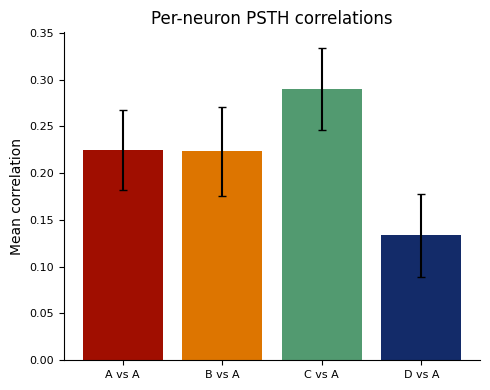

In [ ]:
# Plot reward PSTHs for each goal and get correlation across goals 
ABCD_goals = [1,2,3,4]
psths = [{} for _ in range(num_sessions)]
average_psths = [{} for _ in range(num_sessions)]
goal_ids = ['A','B','C','D']
color_scheme = palettes.met_brew('Johnson', n=len(ABCD_goals), brew_type="continuous")

for s, prot in enumerate(protocol_nums): 
    if prot >= 5: 
        neurons = np.array(neurons_considered_sessions[s])[consistent_reward_tuned_neuron_idx]  # ids of tracked neurons that are consistently reward-tuned 
        neuron_idx = np.where(np.isin(neurons_considered[s], neurons))[0]   # indices of these neurons inside their original list of neurons considered 

        for goal in ABCD_goals:
            psths[s][goal] = results_rewards[s]['reward_id_psth'][()][goal][neuron_idx]
            average_psths[s][goal] = results_rewards[s]['average_reward_id_psth'][()][goal][neuron_idx]

        plot_goal_psth_map(average_psths[s], zscoring=True, sorting_goal=1, time_around=time_around, funcimg_frame_rate=45, save_plot=False, savepath=savepath, \
                        savedir='RewardPSTH_RewardTunedNeurons', filename=f'ABCD_Reward_PSTH_T{protocol_nums[s]}')

        # Plot correlation for each sess among goals 
        corrs = get_map_correlation(psths[s], average_psths[s], conditions=goal_ids, zscoring=True, reference=1, color_scheme=color_scheme, \
                                save_plot=False, savepath=savepath, savedir='RewardPSTH_RewardTunedNeurons', filename=f'ABCD_FiringMap_correlation_T{protocol_nums[s]}')

if np.all(np.array(protocol_nums) >= 5):
    plot_all_sessions_goal_psth_map(average_psths, zscoring=True, ref_session=ref_prot, sorting_goal=1, time_around=time_around, funcimg_frame_rate=45, save_plot=False, savepath=savepath, \
                                        savedir='RewardPSTH_RewardTunedNeurons', filename=f'ABCD_Reward_PSTH_allSessions')

##### Compare PSTH maps across goals and sessions 

In [83]:
# Compare reward-tuned neurons that are goal-specific across sessions 
ABCD_goals = [1,2,3,4]
goal_ids = ['A','B','C','D']
conditions = [f'T{prot} {goal}' if prot >= 5 else f'T{prot} A' for prot in protocol_nums for goal in (goal_ids if prot >= 5 else ['A'])]
color_scheme = palettes.met_brew('Johnson', n=len(conditions)*2, brew_type="continuous")
if len(conditions) == 5:
    color_scheme = [color_scheme[1], color_scheme[3], color_scheme[5], color_scheme[7], color_scheme[0]] 
elif len(conditions) == 8:
    color_scheme = [color_scheme[3], color_scheme[6], color_scheme[9], color_scheme[12], color_scheme[4], color_scheme[7], color_scheme[10], color_scheme[13]]


## Get the neurons that are goal-specific and tracked 
tracked_reward_id_tuned_neurons = {s: {goal: [] for goal in (ABCD_goals if protocol_nums[s] >= 5 else [1])} for s in range(num_sessions)}
tracked_reward_id_tuned_idx = {s: {goal: [] for goal in (ABCD_goals if protocol_nums[s] >= 5 else [1])} for s in range(num_sessions)}
# consistent_reward_id_tuned_neuron_idx = {goal: [] for goal in (ABCD_goals if protocol_nums[s] >= 5 else [1])}

for g, goal in enumerate(ABCD_goals):
    for s, (prot, sess) in enumerate(zip(protocol_nums, sessions_to_align)):
        
        if goal not in tracked_reward_id_tuned_neurons[s]:
            continue

        # Ids of reward-tuned neurons for a specific goal from each session
        if prot < 5:
            tracked_reward_id_tuned_neurons[s][goal] = np.intersect1d(neurons_considered[s][all_significant_neurons_reward[s]], neurons_considered_sessions[s])
        else:
            tracked_reward_id_tuned_neurons[s][goal] = np.intersect1d(neurons_considered[s][significant_neurons_reward_id[s][()][goal]], neurons_considered_sessions[s])
        print(f'Out of {len(neurons_considered_sessions[s])} neurons considered across all sessions, {len(tracked_reward_id_tuned_neurons[s][goal])} have been previously identified as {conditions[g]} reward-tuned in T{prot}.')
         
        # Indices of reward-tuned neurons for a specific goal from each session inside the tracked array. 
        tracked_reward_id_tuned_idx[s][goal] = np.where(np.isin(neurons_considered_sessions[s], tracked_reward_id_tuned_neurons[s][goal]))[0]

    # Indices of tracked neurons that are reward-tuned for a specific goal across sessions.
    # consistent_reward_id_tuned_neuron_idx[goal] = reduce(np.intersect1d, [tracked_reward_id_tuned_idx[s][goal] for s in range(num_sessions) if goal in tracked_reward_id_tuned_idx[s]])


Out of 106 neurons considered across all sessions, 56 have been previously identified as T4 A reward-tuned in T4.
Out of 106 neurons considered across all sessions, 34 have been previously identified as T4 A reward-tuned in T5.
Out of 106 neurons considered across all sessions, 31 have been previously identified as T5 A reward-tuned in T5.
Out of 106 neurons considered across all sessions, 33 have been previously identified as T5 B reward-tuned in T5.
Out of 106 neurons considered across all sessions, 30 have been previously identified as T5 C reward-tuned in T5.


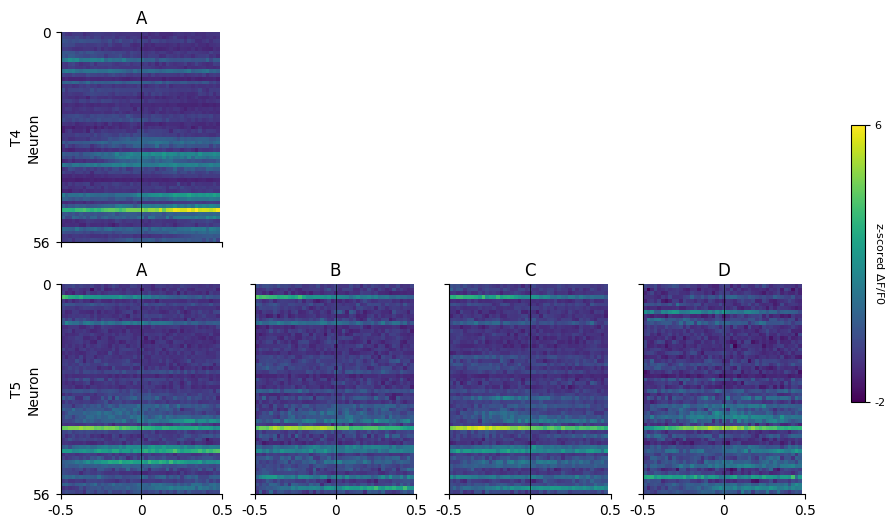

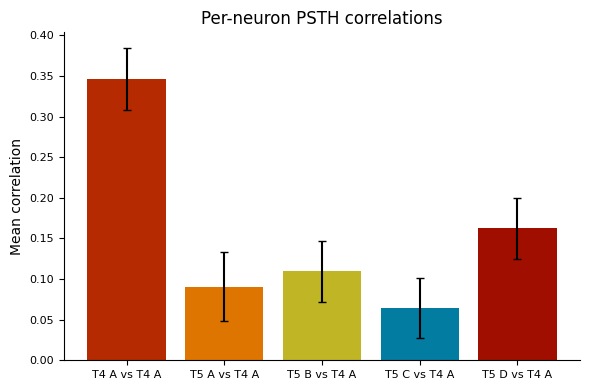

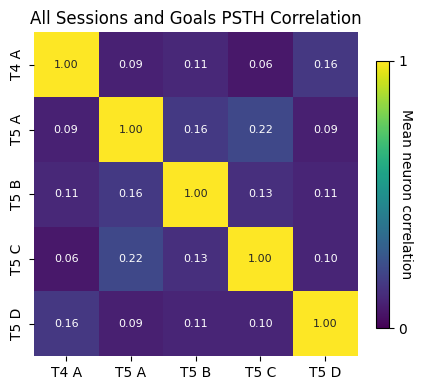

In [84]:
## Get PSTH maps and their correlations for each goal compared
all_references = [(prot, goal) for prot in tracked_reward_id_tuned_idx.keys() for goal in tracked_reward_id_tuned_idx[prot].keys()]

goal_label_map = {1: 'A', 2: 'B', 3: 'C', 4: 'D', '1': 'A', '2': 'B', '3': 'C', '4': 'D', 'A': 'A', 'B': 'B', 'C': 'C', 'D': 'D'}

ref_prot = 0  # session idx to use as reference i.e. how have things changed compared to that session

for ref_goal in tracked_reward_id_tuned_idx[ref_prot].keys():
    goal_id = goal_label_map.get(ref_goal, str(ref_goal))

    psths = {s: {goal: [] for goal in (ABCD_goals if protocol_nums[s] >= 5 else [1])} for s in range(num_sessions)}
    average_psths = {s: {goal: [] for goal in (ABCD_goals if protocol_nums[s] >= 5 else [1])} for s in range(num_sessions)}

    for s in range(num_sessions):
        # neurons = np.array(neurons_considered_sessions[s])[consistent_reward_id_tuned_neuron_idx[goal]]  # ids of tracked neurons that are consistently reward-tuned 
        neurons = np.array(neurons_considered_sessions[s])[tracked_reward_id_tuned_idx[ref_prot][ref_goal]]    # ids of tracked neurons that are reward-tuned and goal-specific in the *1st session*
        neuron_idx = np.where(np.isin(neurons_considered[s], neurons))[0]   # indices of these neurons inside their original list of neurons considered 

        for goal in ABCD_goals:
            if goal not in tracked_reward_id_tuned_idx[s]:
                continue
            # Extract the reward PSTHs for these neurons
            if 'reward_id_psth' in results_rewards[s]:
                psths[s][goal] = results_rewards[s]['reward_id_psth'][()][goal][neuron_idx]
                average_psths[s][goal] = results_rewards[s]['average_reward_id_psth'][()][goal][neuron_idx]
            else:
                psths[s][goal] = results_rewards[s]['reward_psth'][neuron_idx]
                average_psths[s][goal] = results_rewards[s]['average_reward_psth'][neuron_idx]
     
    plot_all_sessions_goal_psth_map(average_psths, conditions=conditions, zscoring=True, ref_session=ref_prot, sorting_goal=ref_goal, \
                                    time_around=time_around, funcimg_frame_rate=45, save_plot=False, savepath=savepath, \
                                    savedir='RewardPSTH_RewardTunedNeurons', filename=f'ABCD_T{protocol_nums[ref_prot]}-Reward{goal_id}-TunedNeurons_PSTH_allSessions')

    # Get correlation among goals and across sessions compared to reference
    reference = all_references.index((ref_prot, ref_goal))
    _ = get_map_correlation(psths, average_psths, conditions, zscoring=True, reference=reference, color_scheme=color_scheme, \
                            save_plot=False, savepath=savepath, savedir='RewardPSTH_RewardTunedNeurons', \
                                filename=f'ABCD_FiringMap_correlation_T{protocol_nums[ref_prot]}-Reward{goal_id}-TunedNeurons')
    
    # Get correlation matrix among goals and across sessions 
    _ = get_map_correlation_matrix(average_psths, conditions, zscoring=True, save_plot=False, savepath=savepath, savedir='RewardPSTH_RewardTunedNeurons',\
                                   filename=f'ABCD_FiringMap_correlationMatrix_T{protocol_nums[ref_prot]}-Reward{goal_id}-TunedNeurons')


##### Compare PSTH maps according to landmark id 

In [85]:
# Get the landmark ids and categories for each session 

session_struct = {}

for s, (protocol_num, sess) in enumerate(zip(protocol_nums, sessions_to_align)):
    data = load_nidaq_behaviour_data(os.path.join(basepath, animal, sess))
    position_data, options = load_vr_behaviour_data(os.path.join(basepath, animal, sess))

    session = create_session_struct(position_data, options)

    session = get_lap_idx(session)
    session = get_lm_idx(session)
    session = get_rewarded_lms(session)
    session = get_active_goal(session)
    session = calc_laps_needed(session)
    session = get_lms_visited(options, session)

    rulename = options['sequence_task']['rulename']
    if rulename == 'olfactory_shaping' or rulename == 'olfactory_test':  # stages 3-6
        if rulename == 'olfactory_test':
            num_landmarks = 10
        else:
            num_landmarks = 2
    else:
        raise ValueError('Not sure how to deal with this timepoint yet.')
            
    if animal == 'TAA0000066' or animal == 'TAA0000059':
        if protocol_num == 3 or protocol_num == 4:
            sequence = 'AB_shuffled'
        elif protocol_num == 5 or protocol_num == 6:
            sequence = 'ABAB'
        else:
            print('This code does not work before T3 or beyond T6 yet.')
    elif animal == 'TAA0000061' or animal == 'TAA0000064':
        if protocol_num == 3 or protocol_num == 4:
            sequence = 'AABB'
        elif protocol_num == 5 or protocol_num == 6:
            sequence = 'ABAB'
        else:
            print('This code does not work before T3 or beyond T6 yet.')
    elif animal == 'TAA0000062' or animal == 'TAA0000065':
        if protocol_num == 3 or protocol_num == 4:
            sequence = 'AB_shuffled'
        elif protocol_num == 5 or protocol_num == 6:
            sequence = 'AABB'
        else:
            print('This code does not work before T3 or beyond T6 yet.')
    else:
        raise ValueError("Oops I don't know what to do about this mouse")

    session = get_landmark_categories(sequence, num_landmarks, session)
 
    print(f"T{protocol_num} goal: {session['goal_landmark_id']}")
    print(f"T{protocol_num} non_goal: {session['non_goal_landmark_id']}")
    print(f"T{protocol_num} test: {session['test_landmark_id']}")

    session = get_landmark_category_rew_idx(sequence, num_landmarks, session, position_data, data)

    session_struct[s] = session     # TODO: save

 

Speed threshold: 7
T4 goal: 0
T4 non_goal: 3
T4 test: None
Total rewards considered here:  125
Total rewards not considered here:  0
Total assistant and manual rewards:  0
Reward time lag from lm entry:  17.0
Speed threshold: 7
T5 goal: [1 3 5 7]
T5 non_goal: [0 2 4 6 8]
T5 test: 9
Total rewards considered here:  100
Total rewards not considered here:  9
Total assistant and manual rewards:  9
Reward time lag from lm entry:  27.0


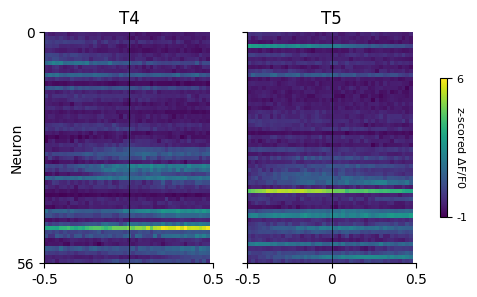

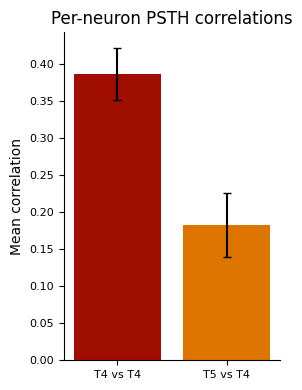

In [99]:
# 1. Compare T4 reward PSTH vs T5 goal-average ABCD reward PSTH
conditions = [f'T{prot}' for prot in protocol_nums]
goal_label_map = {1: 'A', 2: 'B', 3: 'C', 4: 'D', '1': 'A', '2': 'B', '3': 'C', '4': 'D', 'A': 'A', 'B': 'B', 'C': 'C', 'D': 'D'}
all_references = [(prot, goal) for prot in tracked_reward_id_tuned_idx.keys() for goal in tracked_reward_id_tuned_idx[prot].keys()]
ref_prot = 0  # session idx to use as reference i.e. how have things changed compared to that session
color_scheme = palettes.met_brew('Johnson', n=len(conditions)*2, brew_type="continuous")

for ref_goal in tracked_reward_id_tuned_idx[ref_prot].keys():
    goal_id = goal_label_map.get(ref_goal, str(ref_goal))

    psths = {s: {goal: [] for goal in (ABCD_goals if protocol_nums[s] >= 5 else [1])} for s in range(num_sessions)}
    average_psths = {s: {goal: [] for goal in (ABCD_goals if protocol_nums[s] >= 5 else [1])} for s in range(num_sessions)}
    average_across_goals = {s: {1: []} for s in range(num_sessions)}
    psths_across_goals = {s: {1: []} for s in range(num_sessions)}

    for s in range(num_sessions):
        # neurons = np.array(neurons_considered_sessions[s])[consistent_reward_id_tuned_neuron_idx[goal]]  # ids of tracked neurons that are consistently reward-tuned 
        neurons = np.array(neurons_considered_sessions[s])[tracked_reward_id_tuned_idx[ref_prot][ref_goal]]    # ids of tracked neurons that are reward-tuned and goal-specific in the *1st session*
        neuron_idx = np.where(np.isin(neurons_considered[s], neurons))[0]   # indices of these neurons inside their original list of neurons considered 

        for goal in ABCD_goals:
            if goal not in tracked_reward_id_tuned_idx[s]:
                continue
            # Extract the reward PSTHs for these neurons
            if 'reward_id_psth' in results_rewards[s]:
                psths[s][goal] = results_rewards[s]['reward_id_psth'][()][goal][neuron_idx]
                average_psths[s][goal] = results_rewards[s]['average_reward_id_psth'][()][goal][neuron_idx]  
    
            else:
                psths[s][goal] = results_rewards[s]['reward_psth'][neuron_idx]
                average_psths[s][goal] = results_rewards[s]['average_reward_psth'][neuron_idx]

        mean_goal_psths = [average_psths[s][goal] for goal in ABCD_goals if goal in average_psths[s] and len(average_psths[s][goal]) > 0]
        goal_psths = [psths[s][goal] for goal in ABCD_goals if goal in psths[s] and len(psths[s][goal] > 0)]
        if mean_goal_psths:  
            average_across_goals[s] = np.mean(np.stack(mean_goal_psths, axis=0), axis=0)  # average over goals (axis=0)
            psths_across_goals[s] = np.concatenate(goal_psths, axis=1)
        else:
            average_across_goals[s] = average_psths[s][goal]

    plot_all_sessions_goal_psth_map(all_average_psths=average_across_goals, conditions=conditions, zscoring=True, ref_session=ref_prot, sorting_goal=1, \
                                    time_around=time_around, funcimg_frame_rate=45, save_plot=False, savepath=savepath, \
                                    savedir='RewardPSTH_RewardTunedNeurons', filename=f'A-avgABCD_T{protocol_nums[ref_prot]}-Reward{goal_id}-TunedNeurons_PSTH_allSessions')

    reference = all_references.index((ref_prot, ref_goal))
    _ = get_map_correlation(psths=psths_across_goals, average_psths=average_across_goals, conditions=conditions, zscoring=True, reference=reference, color_scheme=color_scheme, \
                            save_plot=False, savepath=savepath, savedir='RewardPSTH_RewardTunedNeurons', \
                                filename=f'A-avgABCD_FiringMap_correlation_T{protocol_nums[ref_prot]}-Reward{goal_id}-TunedNeurons')
    

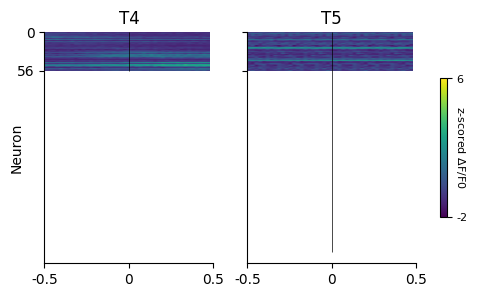

In [ ]:
# 2. Compare T4 reward PSTH vs T5 non-goal PSTH for that landmark 

# Get non-goal PSTH by landmark id 
sess_goal = 0       # session where landmark of interest is goal
sess_nongoal = 1    # session where landmark of interest is non-goal
conditions = [f'T{prot} goal' if p == sess_goal else f'T{prot} non-goal' for p, prot in enumerate(protocol_nums)]
color_scheme = palettes.met_brew('Johnson', n=len(conditions)*2, brew_type="continuous")

# Find landmark indices for landmark that is rewarded in T4 and not in T5
lm_idx = np.where(session_struct[sess_nongoal]['all_lms'] == session_struct[sess_goal]['goal_landmark_id'])[0]

# Get 'reward' indices for these landmarks 
lm_rew_idx = get_imag_rew_idx(lm_idx, session_struct[1]['rew_time_lag'])

# Get PSTH for these events (use all neurons)
nongoal_lm_id_psth, average_nongoal_lm_id_psth = get_psth(data=session_data[sess_nongoal], neurons=neurons_considered[sess_nongoal], event_idx=lm_rew_idx, \
                                                            time_around=time_around)

# TODO: Match neurons 
# plot_all_sessions_goal_psth_map(all_average_psths=[average_across_goals[0],average_nongoal_lm_id_psth], conditions=conditions, zscoring=True, ref_session=ref_prot, sorting_goal=1, \
#                                     time_around=time_around, funcimg_frame_rate=45, save_plot=False, savepath=savepath, \
#                                     savedir='RewardPSTH_RewardTunedNeurons', filename=f'A-avgABCD_T{protocol_nums[ref_prot]}-Reward{goal_id}-TunedNeurons_PSTH_allSessions')



In [ ]:
# 3. Compare T4 non-goal PSTH vs T5 reward PSTH for that landmark

##### Neuronal overlap analysis

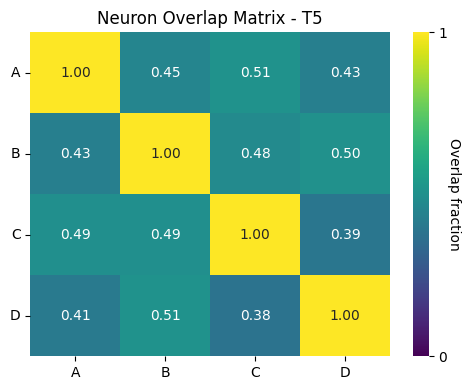

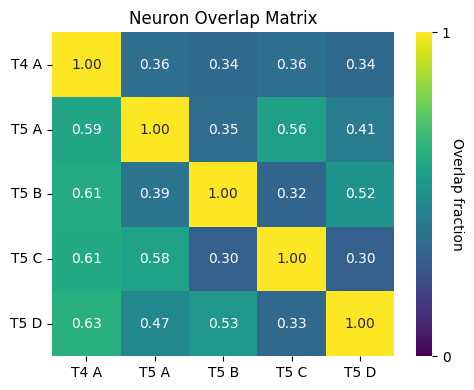

In [ ]:
# Find the overlap in reward-tuned neurons among goals in each session 
save_plot = False

ABCD_goals = [1,2,3,4]
goal_ids = ['A','B','C','D']
conditions = [f'T{prot} {goal}' if prot >= 5 else f'T{prot} A' for prot in protocol_nums for goal in (goal_ids if prot >= 5 else ['A'])]

for s in range(num_sessions):
    if protocol_nums[s] >= 5:
        neuron_overlap_matrix = np.zeros((len(ABCD_goals), len(ABCD_goals)))

        # Find overlapping neurons
        for i, goal in enumerate(ABCD_goals):
            for j, goal_test in enumerate(ABCD_goals):

                neurons1 = neurons_considered[s][significant_neurons_reward_id[s][()][goal]]
                neurons2 = neurons_considered[s][significant_neurons_reward_id[s][()][goal_test]]
                
                overlap = len(np.where(np.isin(neurons1, neurons2))[0])
                perc_overlap = overlap / len(neurons1)
                
                neuron_overlap_matrix[i,j] = perc_overlap
        
        # Plotting
        fig, ax = plt.subplots(figsize=(5,4))
        h = sns.heatmap(neuron_overlap_matrix, 
                    annot=True,        
                    fmt=".2f",          
                    cmap="viridis", 
                    vmin=0, vmax=1, 
                    cbar=True,         
                    xticklabels=goal_ids, 
                    yticklabels=goal_ids, 
                    ax=ax)
        
        cbar = h.collections[0].colorbar
        cbar.set_label('Overlap fraction', rotation=270, labelpad=10)  
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels(['0', '1'])
        ax.set_title(f'Neuron Overlap Matrix - T{protocol_nums[s]}')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')

        plt.tight_layout()

        if save_plot:
            output_path = os.path.join(savepath, 'RewardPSTH_RewardTunedNeurons')
            if not os.path.exists(output_path):
                os.makedirs(output_path)
            plt.savefig(os.path.join(output_path, f'neuron_goal_overlap_matrix_T{protocol_nums[s]}.png'))


# Find the overlap in reward-tuned neurons among goals aross sessions
# conditions = [f'T{prot} {goal}' for prot in protocol_nums for goal in goal_ids]

neuron_overlap_matrix = np.zeros((len(conditions), len(conditions)))
neurons1 = [{} for _ in range(len(conditions))]

counter = 0
for s in range(num_sessions):
    for i, goal in enumerate(ABCD_goals):
        if goal not in tracked_reward_id_tuned_idx[s]:
            continue
        neurons1[counter] = tracked_reward_id_tuned_idx[s][goal] 
        counter += 1

for i in range(counter):
    for j in range(counter):
        overlap = len(np.where(np.isin(neurons1[i], neurons1[j]))[0])
        perc_overlap = overlap / len(neurons1[i])
        neuron_overlap_matrix[i,j] = perc_overlap

# Plotting  
fig, ax = plt.subplots(figsize=(5,4))
h = sns.heatmap(neuron_overlap_matrix, 
            annot=True,        
            fmt=".2f",          
            cmap="viridis", 
            vmin=0, vmax=1, 
            cbar=True,         
            xticklabels=conditions, 
            yticklabels=conditions, 
            ax=ax)

cbar = h.collections[0].colorbar
cbar.set_label('Overlap fraction', rotation=270, labelpad=10)  
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['0', '1'])
ax.set_title(f'Neuron Overlap Matrix')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')

plt.tight_layout()

if save_plot:
    output_path = os.path.join(savepath, 'RewardPSTH_RewardTunedNeurons')
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    plt.savefig(os.path.join(output_path, f'neuron_goal_overlap_matrix_allSessions.png'))

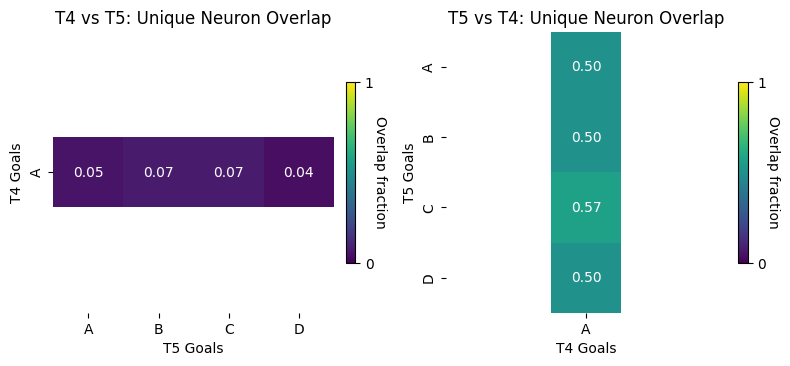

In [ ]:
# What do goal-specific neurons do across sessions? 
save_plot = False
plotting = True

ABCD_goals = [1,2,3,4]
goal_ids = ['A','B','C','D']
conditions = [f'T{prot} {goal}' if prot >= 5 else f'T{prot} A' for prot in protocol_nums for goal in (goal_ids if prot >= 5 else ['A'])]

# Find neurons that are goal-specific for each goal and session
unique_neurons = {s: {goal: [] for goal in (ABCD_goals if protocol_nums[s] >= 5 else [1])} for s in range(num_sessions)}

for s in range(num_sessions):
    if len(tracked_reward_id_tuned_idx[s].keys()) == 1:
        goal = list(tracked_reward_id_tuned_idx[s].keys())[0]
        unique_neurons[s][goal] = tracked_reward_id_tuned_idx[s][goal]
    else:
        for goal in ABCD_goals:
            if goal not in tracked_reward_id_tuned_idx[s]:
                continue
            neurons_other_goals = list(set().union(*[tracked_reward_id_tuned_idx[s][g] for g in ABCD_goals if g != goal and g in tracked_reward_id_tuned_idx[s]]))
            unique_neurons[s][goal] = np.setdiff1d(tracked_reward_id_tuned_idx[s][goal], neurons_other_goals)

# Find overlap of goal-specific neurons with goal-specific neurons in other sessions
neuron_overlap_matrix = np.zeros((len(conditions), len(conditions)))
neurons1 = [{} for _ in range(len(conditions))]

counter = 0
for s in range(num_sessions):
    for i, goal in enumerate(ABCD_goals):
        if goal not in unique_neurons[s]:
            continue
        neurons1[counter] = unique_neurons[s][goal] 
        counter += 1

for i in range(counter):
    for j in range(counter):
        overlap = len(np.intersect1d(neurons1[i], neurons1[j]))
        perc_overlap = overlap / len(neurons1[i])
        neuron_overlap_matrix[i,j] = perc_overlap

# Plotting
if plotting:
    goals_per_session = [[g for g in ABCD_goals if g in tracked_reward_id_tuned_idx[s]] for s in range(num_sessions)]
    rows = [0 * len(goals_per_session[0]) + g for g in range(len(goals_per_session[0]))]
    cols = [1 * len(goals_per_session[0]) + g for g in range(len(goals_per_session[1]))]
    
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    ax = ax.ravel()

    # Plot T_early vs T_late
    xticklabels = [goal_label_map.get(g, str(g)) for g in goals_per_session[1]]
    yticklabels = [goal_label_map.get(g, str(g)) for g in goals_per_session[0]]

    t5_vs_t6 = neuron_overlap_matrix[np.ix_(rows, cols)]
    h1 = sns.heatmap(t5_vs_t6, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=xticklabels,
                yticklabels=yticklabels,
                cbar=False, ax=ax[0],
                vmin=0, vmax=1, square=True)
    ax[0].set_title(f"T{protocol_nums[0]} vs T{protocol_nums[1]}: Unique Neuron Overlap")
    ax[0].set_xlabel(f"T{protocol_nums[1]} Goals")
    ax[0].set_ylabel(f"T{protocol_nums[0]} Goals")
    ax[0].set_box_aspect(1)

    # Plot T_late vs T_early
    t6_vs_t5 = neuron_overlap_matrix[np.ix_(cols, rows)]
    h2 = sns.heatmap(t6_vs_t5, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=yticklabels,
                yticklabels=xticklabels,
                cbar=False, ax=ax[1],
                vmin=0, vmax=1, square=True)
    ax[1].set_title(f"T{protocol_nums[1]} vs T{protocol_nums[0]}: Unique Neuron Overlap")
    ax[1].set_xlabel(f"T{protocol_nums[0]} Goals")
    ax[1].set_ylabel(f"T{protocol_nums[1]} Goals")
    ax[1].set_box_aspect(1)

    cbar = fig.colorbar(h1.collections[0], ax=ax[0], orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label('Overlap fraction', rotation=270, labelpad=10)  
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['0', '1'])
    cbar = fig.colorbar(h2.collections[0], ax=ax[1], orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label('Overlap fraction', rotation=270, labelpad=10)  
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['0', '1'])

    plt.tight_layout()

    if save_plot:
        output_path = os.path.join(savepath, 'RewardPSTH_RewardTunedNeurons')
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        plt.savefig(os.path.join(output_path, f'neuron_uniqueGoal_overlap_matrix.png'))


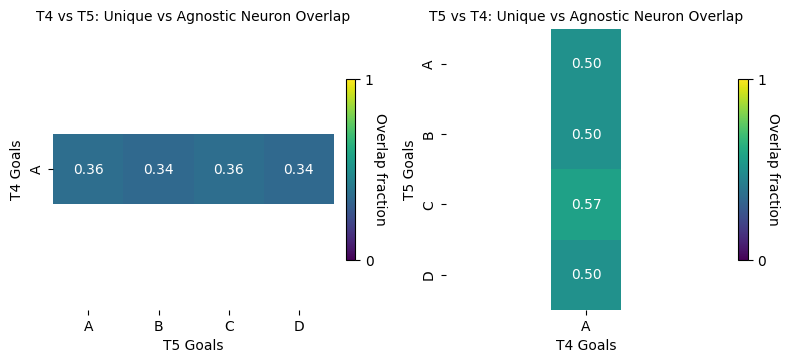

In [ ]:
# Find overlap of goal-specific neurons with other reward-tuned neurons (unique and agnostic) in other goals in other sessions
save_plot = False
plotting = True

neuron_overlap_matrix = np.zeros((len(conditions), len(conditions)))
neurons1 = [{} for _ in range(len(conditions))]
neurons2 = [{} for _ in range(len(conditions))]

counter = 0
for s in range(num_sessions):
    for i, goal in enumerate(ABCD_goals):
        if goal not in unique_neurons[s] or goal not in tracked_reward_id_tuned_idx[s]:
            continue
        neurons1[counter] = unique_neurons[s][goal] 
        neurons2[counter] = tracked_reward_id_tuned_idx[s][goal]
        counter += 1

for i in range(counter):
    for j in range(counter):
        overlap = len(np.intersect1d(neurons1[i], neurons2[j]))
        perc_overlap = overlap / len(neurons1[i])
        neuron_overlap_matrix[i,j] = perc_overlap

# Plot the overlap across sessions
if plotting:
    goals_per_session = [[g for g in ABCD_goals if g in tracked_reward_id_tuned_idx[s]] for s in range(num_sessions)]
    rows = [0 * len(goals_per_session[0]) + g for g in range(len(goals_per_session[0]))]
    cols = [1 * len(goals_per_session[0]) + g for g in range(len(goals_per_session[1]))]
    
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    ax = ax.ravel()

    # Plot T_early vs T_late
    xticklabels = [goal_label_map.get(g, str(g)) for g in goals_per_session[1]]
    yticklabels = [goal_label_map.get(g, str(g)) for g in goals_per_session[0]]

    # Plot T5 vs T6
    t5_vs_t6 = neuron_overlap_matrix[np.ix_(rows, cols)]
    h1 = sns.heatmap(t5_vs_t6, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=xticklabels,
                yticklabels=yticklabels,
                cbar=False, ax=ax[0],
                vmin=0, vmax=1, square=True)
    ax[0].set_title(f"T{protocol_nums[0]} vs T{protocol_nums[1]}: Unique vs Agnostic Neuron Overlap", fontsize=10)
    ax[0].set_xlabel(f"T{protocol_nums[1]} Goals")
    ax[0].set_ylabel(f"T{protocol_nums[0]} Goals")
    ax[0].set_box_aspect(1)

    # Plot T6 vs T5
    t6_vs_t5 = neuron_overlap_matrix[np.ix_(cols, rows)]
    h2 = sns.heatmap(t6_vs_t5, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=yticklabels,
                yticklabels=xticklabels,
                cbar=False, ax=ax[1],
                vmin=0, vmax=1, square=True)
    ax[1].set_title(f"T{protocol_nums[1]} vs T{protocol_nums[0]}: Unique vs Agnostic Neuron Overlap", fontsize=10)
    ax[1].set_xlabel(f"T{protocol_nums[0]} Goals")
    ax[1].set_ylabel(f"T{protocol_nums[1]} Goals")
    ax[1].set_box_aspect(1)

    cbar = fig.colorbar(h1.collections[0], ax=ax[0], orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label('Overlap fraction', rotation=270, labelpad=10)  
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['0', '1'])
    cbar = fig.colorbar(h2.collections[0], ax=ax[1], orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label('Overlap fraction', rotation=270, labelpad=10)  
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['0', '1'])

    plt.tight_layout()

    if save_plot:
        output_path = os.path.join(savepath, 'RewardPSTH_RewardTunedNeurons')
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        plt.savefig(os.path.join(output_path, f'neuron_uniqueGoal_vs_agnosticGoal_overlap_matrix.png'))


##### Saving some info 

In [154]:
# Save neuron ids to visualize them later
filename = os.path.join(savepath, 'tracked_reward_tuned_neurons.npz')
tracked_neurons_save = {}
tracked_neurons_save['tracked_reward_id_tuned_idx'] = tracked_reward_id_tuned_idx
tracked_neurons_save['neurons_considered_sessions'] = neurons_considered_sessions
tracked_neurons_save['unique_neurons'] = unique_neurons
np.savez(filename, **tracked_neurons_save)
